This notebook implements an efficient version of pseudobulk nb-glm based differential expression analysis with DESeq2. Pseudobulk means that all reads from a single batch group (e.g. donor) get pooled into a single observation. 

In general, pseudobulk is statistically preferable to but much slower than Wilcoxon, especially when you need to consider covariates. A more robust but considerably slower alternative to pseudobulk is including donors as random effects. Random effects are preferable for small cell count groups but likely give similar results to pseudobulk estimates for large groups. 

This idea is not at all new. The earliest reference I know for is from Lun et al: 
https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7. 


A few implementation notes: 

1) To find markers most upregulated in a cluster, I divide samples into those in and out of the cluster. An alternative is to let each out group remain an independent pseudobulk sample. This is in fact the recommended way from Mike Love: https://support.bioconductor.org/p/118090/. While this is certainly faster than re-estimate size factors for each cluster-specific analysis, I find it gives strange results. Namely, I get more inflated p-values and significant p-values for the wrong canonical marker genes (e.g. CD14 for B cells).  

2) On my laptop, it takes ~20 seconds to run do ~3000 genes from 2700 cells, 3 donors, 2 batches, and 9 cell types. 

# Load some data

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(presto)
    library(singlecellmethods)
    library(SeuratData)
    library(Seurat)
    library(DESeq2)    
})


Warning message:
“package ‘DESeq2’ was built under R version 3.6.1”Warning message:
“package ‘S4Vectors’ was built under R version 3.6.1”Warning message:
“package ‘BiocGenerics’ was built under R version 3.6.1”Warning message:
“package ‘IRanges’ was built under R version 3.6.1”Warning message:
“package ‘GenomicRanges’ was built under R version 3.6.1”Warning message:
“package ‘GenomeInfoDb’ was built under R version 3.6.1”Warning message:
“package ‘SummarizedExperiment’ was built under R version 3.6.1”Warning message:
“package ‘Biobase’ was built under R version 3.6.1”Warning message:
“package ‘DelayedArray’ was built under R version 3.6.1”Warning message:
“package ‘BiocParallel’ was built under R version 3.6.1”

Load small dataset for exposition

In [2]:
if (!SeuratData::AvailableData()['pbmc3k.SeuratData', 'Installed']) {
    SeuratData::InstallData("pbmc3k")
}
data("pbmc3k")

Add fake donor and batch columns

In [3]:
pbmc3k@meta.data$donor <- factor(sample(LETTERS[1:3], ncol(pbmc3k), TRUE))
pbmc3k@meta.data$batch <- factor(sample(LETTERS[1:2], ncol(pbmc3k), TRUE))

In [4]:
head(pbmc3k@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,seurat_annotations,donor,batch
,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>
AAACATACAACCAC,pbmc3k,2419,779,Memory CD4 T,C,A
AAACATTGAGCTAC,pbmc3k,4903,1352,B,C,B
AAACATTGATCAGC,pbmc3k,3147,1129,Memory CD4 T,C,A
AAACCGTGCTTCCG,pbmc3k,2639,960,CD14+ Mono,B,B
AAACCGTGTATGCG,pbmc3k,980,521,NK,A,B
AAACGCACTGGTAC,pbmc3k,2163,781,Memory CD4 T,B,B


# Functions

## Collapse to pseudobulk

In [5]:
compute_hash <- function(data_df, vars_use) {
    base <- 1
    hash <- rep(0, nrow(data_df))
    for (varname in vars_use) {
        vals <- factor(data.frame(data_df)[, varname, drop = TRUE])
        nlevel <- nlevels(vals)
        hash <- hash + (as.integer(vals) - 1) * base
        base <- base * nlevel
    }
    return(hash)
}


In [27]:
collapse_counts <- function(counts_mat, meta_data, varnames) {
    ## give each unique row a hash value for indexing
    hash <- compute_hash(meta_data, varnames)
    idx_keep <- which(!is.na(hash))
    hash <- hash[idx_keep]
    hash <- factor(sprintf('sample_%d', as.integer(hash)))
    meta_data <- meta_data[idx_keep, ]
    counts_mat <- counts_mat[, idx_keep]
    
    ## one hot encoded design matrix, sample level
    design_collapsed <- data.frame(meta_data)[, varnames, drop = FALSE] %>% 
        cbind(sample_id = hash) %>% 
        unique()
    row.names(design_collapsed) <- design_collapsed$sample_id

    ## sum over samples
    counts_collapsed <- presto:::sumGroups(counts_mat, hash, 1) %>% t()
    row.names(counts_collapsed) <- row.names(counts_mat)
    colnames(counts_collapsed) <- levels(hash)

    ## reorder to match design matrix
    counts_collapsed <- counts_collapsed[, design_collapsed$sample_id]
    design_collapsed$sample_id <- NULL
    return(list(counts_mat = counts_collapsed, meta_data = design_collapsed))
}

## DESeq2 wrappers

In [32]:
pseudobulk_deseq2 <- function(dge_formula, meta_data, counts_df, verbose=TRUE, 
                   min_counts_per_sample=10, present_in_min_samples=5, collapse_background=TRUE) {
    message('WARNING: meta_data should only contain pseudobulk identifying variables')
    
    ## filter low expressed genes
    genes_keep <- which(Matrix::rowSums(counts_df >= min_counts_per_sample) >= present_in_min_samples)
    if (verbose) {
        message(sprintf('Filtered out %d genes, analyzing %d genes', nrow(counts_df) - length(genes_keep), length(genes_keep)))
    }
    counts_df <- counts_df[genes_keep, ]
    
    ## assume that the first variable in formula is the main contrast variable
    all_vars <- unlist(strsplit(tail(as.character(dge_formula), 1), split = ' \\+ '))
    if (verbose) {
        message(sprintf('All vars: %s', paste(all_vars, collapse = ', ')))
    }
    contrast_var <- head(all_vars, 1)
    if (verbose) {
        message(sprintf('Contrast var: %s', contrast_var))
    }
    Reduce(rbind, lapply(unique(meta_data[[contrast_var]]), function(foreground_id) {
        if (verbose) {
            message(foreground_id)      
        }
        suppressMessages({suppressWarnings({
            ## setup design 
            design <- meta_data            
            design[[contrast_var]] <- factor(ifelse(design[[contrast_var]] == foreground_id,
                                               paste0('cluster_', foreground_id), 
                                               'background'))
            
            ## background clusters should not be treated as independent observations
            if (collapse_background) {
                res <- collapse_counts(counts_df, design, colnames(design))
                design <- res$meta_data
                counts_df <- res$counts_mat                
            }
                        
            ## Do DGE with DESeq2
            dds <- DESeqDataSetFromMatrix(
                countData = counts_df,
                colData = design,
                design = dge_formula) %>% 
                DESeq2::DESeq()

            ## Get results 
            contrast_name <- grep('cluster.*_vs_background', resultsNames(dds), value = TRUE)
            dge_res <- results(dds, name = contrast_name) %>% 
                    data.frame() %>% 
                    tibble::rownames_to_column('feature') %>% 
                    dplyr::arrange(-stat) %>% 
                    dplyr::mutate(group = foreground_id)
        })})
        return(dge_res)
    })) %>% 
    dplyr::select(group, feature, dplyr::everything())

}

In [31]:
res_mat <- pseudobulk_deseq2(~seurat_annotations + donor, data_collapsed$meta_data, data_collapsed$counts_mat, verbose = TRUE)


Filtered out 10721 genes, analyzing 2993 genes
All vars: seurat_annotations, donor
Contrast var: seurat_annotations
Memory CD4 T


            seurat_annotations donor batch
sample_5  cluster_Memory CD4 T     C     A
sample_10           background     C     B
sample_8            background     B     B
sample_6            background     A     B
sample_9  cluster_Memory CD4 T     B     B
sample_4            background     C     A


B


          seurat_annotations donor batch
sample_4          background     C     A
sample_11          cluster_B     C     B
sample_8          background     B     B
sample_6          background     A     B
sample_10         background     C     B
sample_3           cluster_B     B     A


CD14+ Mono


          seurat_annotations donor batch
sample_4          background     C     A
sample_10         background     C     B
sample_9  cluster_CD14+ Mono     B     B
sample_6          background     A     B
sample_8          background     B     B
sample_2          background     B     A


NK


          seurat_annotations donor batch
sample_4          background     C     A
sample_10         background     C     B
sample_8          background     B     B
sample_7          cluster_NK     A     B
sample_6          background     A     B
sample_2          background     B     A


CD8 T


          seurat_annotations donor batch
sample_4          background     C     A
sample_10         background     C     B
sample_8          background     B     B
sample_6          background     A     B
sample_5       cluster_CD8 T     C     A
sample_11      cluster_CD8 T     C     B


Naive CD4 T


           seurat_annotations donor batch
sample_4           background     C     A
sample_10          background     C     B
sample_8           background     B     B
sample_6           background     A     B
sample_11 cluster_Naive CD4 T     C     B
sample_2           background     B     A


FCGR3A+ Mono


            seurat_annotations donor batch
sample_4            background     C     A
sample_10           background     C     B
sample_8            background     B     B
sample_6            background     A     B
sample_7  cluster_FCGR3A+ Mono     A     B
sample_2            background     B     A


DC


In [19]:
top_markers_dds <- function(res, n=10, pval_max=1, padj_max=1, lfc_min=1) {
    res %>% 
        dplyr::filter(
            .data$pvalue <= pval_max & 
            .data$padj <= padj_max  &
            log2FoldChange >= lfc_min
        ) %>%
        dplyr::group_by(.data$group) %>%
        dplyr::top_n(n = n, wt = .data$stat) %>% 
        dplyr::mutate(rank = rank(-.data$stat, ties.method = 'random')) %>% 
        dplyr::ungroup() %>% 
        dplyr::select(.data$feature, .data$group, .data$rank) %>% 
        tidyr::spread(.data$group, .data$feature, fill = NA) %>% 
        identity()
}

# Test 

## Collapse to pseudobulk

In [30]:
data_collapsed <- collapse_counts(pbmc3k@assays$RNA@counts, 
                                  pbmc3k@meta.data, 
                                  c('seurat_annotations', 'donor', 'batch'))
head(data_collapsed$meta_data)

,seurat_annotations,donor,batch
,<fct>,<fct>,<fct>
sample_19,Memory CD4 T,C,A
sample_48,B,C,B
sample_38,CD14+ Mono,B,B
sample_33,NK,A,B
sample_37,Memory CD4 T,B,B
sample_22,CD8 T,C,A


## Do DESeq2

In [22]:
res_mat <- pseudobulk_deseq2(~seurat_annotations + donor + batch, data_collapsed$meta_data, data_collapsed$counts_mat, verbose = TRUE)


Filtered out 10721 genes, analyzing 2993 genes
All vars: seurat_annotations, donor, batch
Contrast var: seurat_annotations
Memory CD4 T


In [11]:
head(res_mat)

group,feature,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Memory CD4 T,LTB,978.13739,1.489252,0.05461944,27.26596,1.074999e-163,6.434943e-161
Memory CD4 T,IL32,515.07245,1.442222,0.09267988,15.56133,1.333098e-54,1.595984e-52
Memory CD4 T,IL7R,226.90170,1.462490,0.09666429,15.12958,1.033546e-51,1.189771e-49
Memory CD4 T,LDHB,436.32011,1.050225,0.07392476,14.20668,8.328014e-46,8.040563e-44
Memory CD4 T,CD3D,340.79250,1.181639,0.08891563,13.28944,2.665680e-40,2.417691e-38
Memory CD4 T,AQP3,76.07112,2.114533,0.18402614,11.49039,1.474390e-30,9.193437e-29


In [12]:
top_markers_dds(res_mat, lfc_min = 1, padj_max = .05)

rank,Naive CD4 T,Memory CD4 T,CD14+ Mono,B,CD8 T,FCGR3A+ Mono,NK,DC,Platelet
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,RPS27,LTB,S100A8,CD74,CCL5,LST1,FGFBP2,CD74,PF4
2,RPS3A,IL32,S100A9,CD79B,GZMA,COTL1,GZMB,FCER1A,PPBP
3,RPL9,IL7R,S100A6,CD79A,GZMK,AIF1,GNLY,HLA-DPB1,NRGN
4,RPS25,LDHB,LYZ,MS4A1,NKG7,FCGR3A,PRF1,HLA-DRA,GPX1
5,RPL31,CD3D,CTSS,CD37,GZMH,FTL,NKG7,HLA-DRB1,NGFRAP1
6,RPS27A,AQP3,TYROBP,HLA-DQA1,CST7,FTH1,CST7,CST3,TPM4
7,RPS29,CD3E,S100A4,HLA-DRA,CTSW,FCER1G,SPON2,HLA-DPA1,MPP1
8,LDHB,TNFRSF4,CD14,HLA-DRB1,CD8A,CST3,GZMA,CLEC10A,CTSA
9,CCR7,CD2,OAZ1,HLA-DPB1,CD8B,IFITM2,GZMM,HLA-DQA1,GRAP2


## Volcano plots

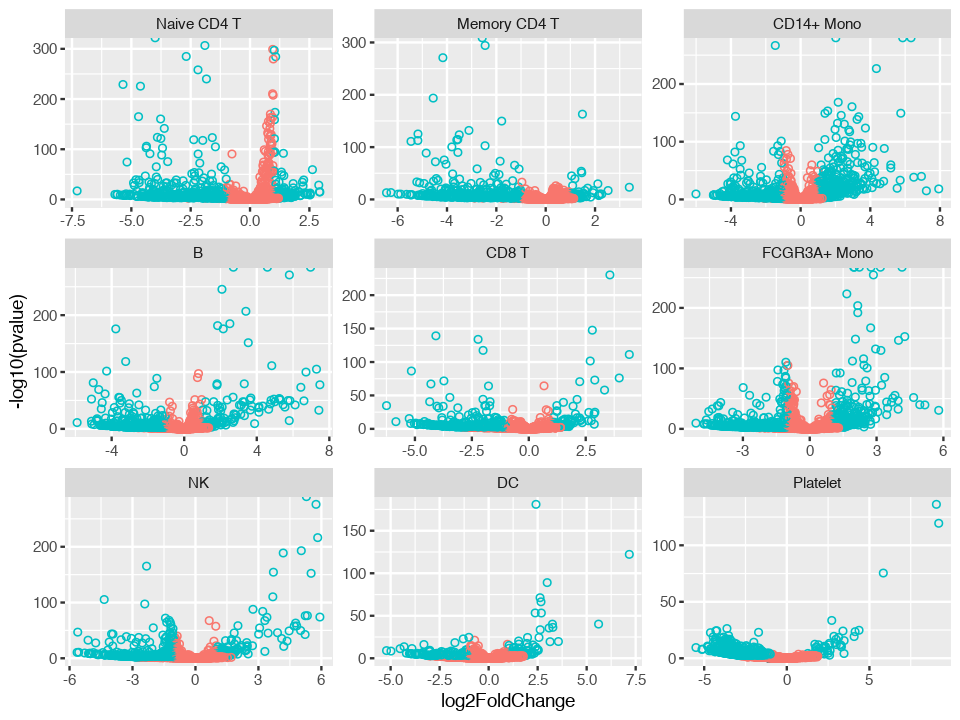

In [13]:
options(repr.plot.height = 6, repr.plot.width = 8)
res_mat %>% 
    ggplot(aes(log2FoldChange, -log10(pvalue), color = padj < .01 & abs(log2FoldChange) > 1)) + 
        geom_point(shape = 21) + 
        facet_wrap(~group, scales = 'free') + 
        guides(color = FALSE) + 
        NULL

# Comparison to Wilcoxon

In this artificial example, donor and batch are fictitious, so DESeq2's GLM $\beta$ estimates should not be that different from the Wilcoxon estimates. Here, we'll compare $\beta$s to auROC, which is essentially equivalent to the Wilxocon statistic. 

In [14]:
## Wilcoxon on CP10K normalized counts 
exprs_norm <- singlecellmethods::normalizeData(pbmc3k@assays$RNA@counts, scaling_factor = 1e4, method = 'log')
dge_wilxocon <- wilcoxauc(exprs_norm, factor(pbmc3k@meta.data$seurat_annotations))


Removing NA values from labels


In [15]:
head(dge_wilxocon)

feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AL627309.1,Naive CD4 T,0.002385006,-0.0041459259,674621.0,0.4986566,0.2969381,0.5033193,0.1434720,0.4121587
AP006222.2,Naive CD4 T,0.000000000,-0.0025103485,675393.0,0.4992272,0.2993548,0.5033193,0.0000000,0.1545595
RP11-206L10.2,Naive CD4 T,0.002616515,0.0001829296,676017.0,0.4996884,0.7459480,0.8712226,0.1434720,0.2060793
RP11-206L10.9,Naive CD4 T,0.000000000,-0.0018526156,675393.0,0.4992272,0.2993548,0.5033193,0.0000000,0.1545595
LINC00115,Naive CD4 T,0.007142957,-0.0051776178,674127.5,0.4982918,0.3475021,0.5567626,0.4304161,0.7727975
NOC2L,Naive CD4 T,0.155593344,-0.0060562808,668592.0,0.4942001,0.3741228,0.5813188,8.6083214,9.9948480


Warning message:
“Column `group` joining character vector and factor, coercing into character vector”

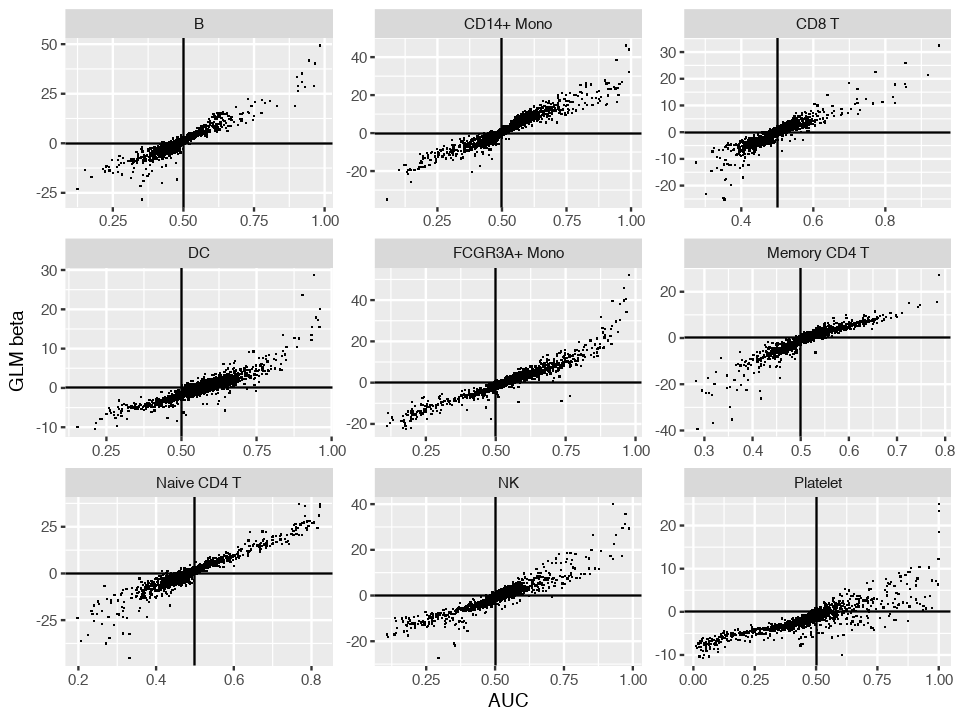

In [16]:
options(repr.plot.height = 6, repr.plot.width = 8)
dplyr::inner_join(dge_wilxocon, res_mat, by = c('feature', 'group')) %>% 
    ggplot(aes(auc, stat)) + 
        geom_point(shape = '.') + 
        facet_wrap(~group, scales = 'free') + 
        geom_vline(xintercept = .5) + 
        geom_hline(yintercept = 0) + 
        labs(x = 'AUC', y = 'GLM beta') + 
        NULL

Most of the results agree, more or less. Interestingly, the Wilcoxon labels almost all genes as upregulated in DCs and CD16+ Monocytes and downregulated in Platelets. What's going on here? It turns out that DCs and CD16+ Monos are mRNA rich cells while platelets are mRNA poor cells overall. DESeq2 is able to account for this effect better than CP10K normalization. 


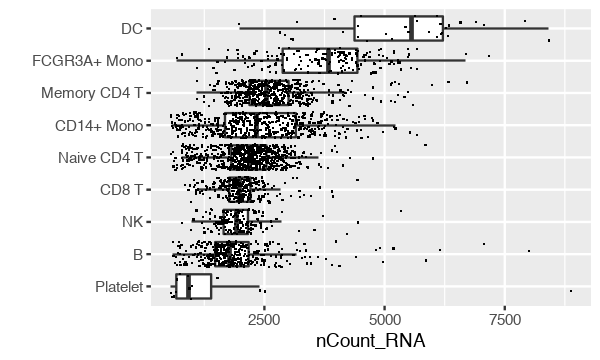

In [17]:
options(repr.plot.height = 3, repr.plot.width = 5)
pbmc3k@meta.data %>% 
    subset(!is.na(seurat_annotations)) %>% 
    ggplot(aes(reorder(seurat_annotations, nCount_RNA), nCount_RNA)) + 
        geom_boxplot(outlier.shape = NA) + 
        geom_jitter(shape = '.', height = 0) + 
        coord_flip() + 
        labs(x = '') + 
        NULL